# Lab 3b - Text Classification of Consumer Complaints

In this lab, you will try to categorize consumer complaints, based on the complaint narrative, using supervised machine learning with Support Vector Machines (SVM). You will also be able to experiment with different forms of data pre-processing to test the effects on the categorization of the text.

### Loading the data

We will use a package called `sklearn` (Scikit-learn) for this lab. This package contains machine learning algorithms for Python focusing on classification, regression and clustering. If you wish, can read more about the details of `sklearn` [here](http://scikit-learn.org/stable/documentation.html) but it is not necessary for completing this lab exercise.

First, let's load the relevant components we will use in this lab:

In [2]:
!pip install textmining3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 11.9 MB/s 


In [3]:
import numpy as np
import pandas as pd
import textmining as tm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Use google drive to load dataset
from google.colab import drive
drive.mount('/content/drive')
gdrive = '/content/drive/MyDrive/data/'

Mounted at /content/drive


Load the data into a `DataFrame` using Pandas and show the head of the data set:

In [5]:
#complaints = pd.read_csv("Consumer_Complaints-sliced.tar.gz")
complaints = pd.read_csv(gdrive + "Consumer_Complaints-sliced.tar.gz")
complaints.head()

,Consumer_Complaints-sliced.csv,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217.0
1,01/19/2017,Student loan,Federal student loan servicing,Dealing with my lender or servicer,Received bad information about my loan,When my loan was switched over to Navient i wa...,NaN,"Navient Solutions, LLC.",LA,NaN,NaN,Consent provided,Web,01/19/2017,Closed with explanation,Yes,No,2296496.0
2,04/06/2018,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,I tried to sign up for a spending monitoring p...,NaN,CAPITAL ONE FINANCIAL CORPORATION,VA,NaN,Older American,Consent provided,Web,04/06/2018,Closed with explanation,Yes,NaN,2866101.0
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638.0
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760.0


If you are unsure what this `.csv` file looks like in its raw format, you check the contents of it in a regular text editor, or by going to the Jupyter dashboard and opening it, just to get a hint of what data we will handle.

Calculate the shape of the dataset. Use the code that you used in Lab 1 to get the shape on `complaints` by replacing the ellipsis (`...`) below with your own code:

In [6]:
complaints.shape

(500001, 18)

**Q1.** How many complaints records are present in the data set?

In [8]:
num_records_in_complaints = complaints.shape[0]
print(f"Num records in complaints: {num_records_in_complaints}")

Num records in complaints: 500001


### What is a Term Document Matrix?

The data set you work with consists of consumer complaints narrative (some description from a consumer about their complaint) alongside a lot of extra data about the complaints, such as when each complaint was made, which company it relates to, and some categorisations such as product or issue category.

For this lab we are interested in looking at the `Product` relating to each complaint. Each row in the dataset corresponds to a complaint. We need to start by creating a TDM that is a representation of these complaints in terms of a feature vector, like we did in Lab 1.

In Lab 1 we used the `textmining` package to create a TDM and do some processing on it. We can experiment with several techniques for optimizing the input dataset and inspect the TDMs after processing.

First, let's compile the corpus from the complaints records:

In [9]:
complaints = complaints.dropna(subset=["Consumer complaint narrative"])  # drops null values
complaints.shape

(72227, 18)

**Q2.** How many complaints records contain non-null narratives?

In [21]:
#num_non_null_records_in_complaints = complaints['Consumer complaint narrative'].notnull().sum()
num_non_null_records_in_complaints = complaints['Consumer complaint narrative'].count()
num_non_null_records_in_complaints

72227

#### Stemming

Stemming is a method where words are shortened to their morphological root. The algorithm that performs this truncation is adapted to the features of specific languages and thus it is not possible to use the same algorithm in Swedish as you would use in English. In this lab we focus on data in English.

We will create three different TDMs based on a sample of the `Consumer_Complaints.csv` dataset. We use a sample initially because the inspecting and manipulating a TDM with a large input dataset easily becomes unworkable. To create samples from using the `sample()` function of a `DataFrame`:

In [22]:
sampled_complaints = complaints.sample(100)  # limits to a sample of 100 records
sampled_complaints.shape

(100, 18)

Now we get our corpus by just considering the `Consumer complaint narrative` column:

In [23]:
sampled_corpus = sampled_complaints["Consumer complaint narrative"]

Now we use the `textmining` package to create our DTM as per Lab 1. Run the following code cell to create our TDM `DataFrame` named `tdm_df`, and then output the head of the new `DataFrame`:

In [34]:
tdm = tm.TermDocumentMatrix()
for complaint in sampled_corpus:
    tdm.add_doc(complaint)
tdm_df = tdm.to_df(cutoff=1)
tdm_df.head()

,someone,applied,for,credit,with,xxxx,and,transunion,gave,access,...,promises,commission,class,illegally,bought,comes,furnished,purchased,yourself,repercussions
0,1,1,3,5,1,19,3,2,2,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,1,4,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,2,1,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,7,2,2,6,18,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,3,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Q3.** How many features (terms) are present in the initial TDM generated from the sampled corpus?

In [43]:
#num_features_sampled = len(sampled_corpus)
num_features_sampled = tdm_df.shape[1]
num_features_sampled

2143

`textmining` provides a function to apply stemming to a corpus of text. We can use the `tm.stem()` function to apply stemming to the complaint narrative corpus. The algorithm applied is the Porter stemming algorithm described in http://snowball.tartarus.org/algorithms/porter/stemmer.html

The following line of code defines a function `stem_doc()` that takes as a parameter a document and returns the document with the individual words in the document already stemmed.

    stem_doc = lambda x: ' '.join(tm.stem(x.split()))
    
Write some code to create a TDM `DataFrame` named `tdm_stemmed_df`, and then output the shape of the new `DataFrame`:

In [44]:
stem_doc = lambda x: ' '.join(tm.stem(x.split()))
tdm_stemmed = tm.TermDocumentMatrix()
for complaint in sampled_corpus:    
    tdm_stemmed.add_doc(stem_doc(complaint))
tdm_stemmed_df = tdm_stemmed.to_df(cutoff=1)
tdm_stemmed_df.head()

,someon,appli,for,credit,with,xxxx,and,transunion,gave,access,...,feedback,promises,commiss,audit,class,systems,bought,dollars,yourself,repercussions
0,1,1,3,5,1,19,3,2,2,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,1,4,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,2,1,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,7,2,2,6,18,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,3,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Q4.** How many features (terms) are present in the stemmed TDM generated from the sampled corpus?

In [45]:
num_features_sampled_stemmed = tdm_stemmed_df.shape[1]
num_features_sampled_stemmed

1886

**Q5.** What do you observe about the shapes of `tdm_df` and `tdm_stemmed_df`?

The features are lower in the stemmed version which seems reasonable since the stemming function shortens the words a bit to their root word.

Let's now study some of the terms in `tdm_df` and` tdm_stemmed_df`.

In [46]:
compare_stemmed = pd.concat([ 
    pd.Series(sorted(tdm_df.columns)), 
    pd.Series(sorted(tdm_stemmed_df.columns))
], ignore_index=True, axis=1)
compare_stemmed.columns = ["Raw terms", "Stemmed terms"]

In [47]:
compare_stemmed[0:50]
# you can change the selection range 20:70 to view other parts of the comparison data set

,Raw terms,Stemmed terms
0,a,a
1,ability,abil
2,able,abl
3,about,about
4,above,above
5,abuse,abus
6,acceptance,accept
7,accepted,acceptance
8,accepts,accepted
9,access,access


**Q6.** How do the terms differ in a TDM with stemming from a TDM without stemming?

The terms differ since the stemming concers the root word of the inputs and since some words will become the same, the two lists above will be disordered when compared in a table. 

#### Stopwords

Stopwords are words of limited importance that do not significantly affect the text analysis. Words that are filtered out are, for example, prepositions (prepositioner) and conjunctions (konjunktioner). The default setting for using the `TermDocumentMatrix` does not remove any words when you use the `add_doc()` function.

- A *preposition*  is a word that tells you where or when something is in relation to something else. For example, words like "after", "before", "on", "under", "inside" and "outside".`
- A *conjunction* is a connective word that join sentences together. For example, the FANBOYS words: "for", "and", "nor", "but", "or", "yet", "so".

To remove the stopwords we use the function `tm.simple_tokenize_remove_stopwords()` applied to each document to add to the TDM. What this function does is takes a document, tokenizes it (splits up the document into a list of individual words), and at the same time removes the stopwords from the list. We then reconstruct the document using `' '.join()`, which takes a list of strings and concatenates them with a space. This results in getting the document with the stopwords removed.

Run the following code to apply this to the sampled corpus:

In [48]:
tdm_stopped = tm.TermDocumentMatrix()
for complaint in sampled_corpus:
    complaint_stopped = ' '.join(tm.simple_tokenize_remove_stopwords(complaint))
    tdm_stopped.add_doc(complaint_stopped)
tdm_stopped_df = tdm_stopped.to_df(cutoff=1)
tdm_stopped_df.head()

,applied,credit,xxxx,transunion,gave,access,history,authorization,approved,applying,...,comply,promises,commission,class,illegally,bought,comes,furnished,purchased,repercussions
0,1,5,19,2,2,1,2,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,6,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Q7.** How many features (terms) are present in the stop word truncated TDM generated from the sampled corpus?

In [53]:
num_features_sampled_stopped = tdm_stopped_df.shape[1]
num_features_sampled_stopped

1944

Study the terms in `tdm_df` and` tdm_stopped_df`. The following code cell creates a table from two `Series` of terms so that you can more easily compare them.

In [54]:
compare_stopped = pd.concat([ 
    pd.Series(tdm_df.columns), 
    pd.Series(tdm_stopped_df.columns)
], ignore_index=True, axis=1)
compare_stopped.columns = ["Raw terms", "Stopped terms"]
compare_stopped[:50]

,Raw terms,Stopped terms
0,someone,applied
1,applied,credit
2,for,xxxx
3,credit,transunion
4,with,gave
5,xxxx,access
6,and,history
7,transunion,authorization
8,gave,approved
9,access,applying


**Q8.** How do the terms differ in a TDM with removal of stopwords from a TDM without truncation?

The tdm with removed stopwords doesn't contain words like "a", "on", or "the". Those words are not as important for the text analysis and are therefore removed.

**Q9.** How does the deletion of stopwords affect the calculation efficiency?

The calculation efficiency is improved since non-important words are filtered out and won't slow down the calculation.

You can inspect the stopwords list used by the `textmining` package as follows:

In [55]:
tm.stopwords

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'b',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'but',
 'by',
 'c',
 'can',
 'cannot',
 'co',
 'could',
 'd',
 'down',
 'during',
 'e',
 'each',
 'eg',
 'either',
 'else',
 'elsewhere',
 'enough',
 'etc',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'f',
 'few',
 'first',
 'for',
 'former',
 'formerly',
 'from',
 'further',
 'g',
 'h',
 'had',
 'has',
 'have',
 'he',
 'hence',
 'her',
 'here',
 'hereafter',
 'hereby',
 'herein',
 'hereupon',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'howev

#### Frequency

In the commands that you execute above, the meaning of words in the feature vectors is recorded based on only the number of occurences of each term in each record of the corpus (the DTM, loaded initially into `tdm_df`).

Another further matrix we can derive is a TF-IDF (term frequency inverse document frequency) matrix. This emphasizes the occurrence of a word in a particular document in relation to whether the word appears in the other documents. This means that if a word occurs in almost all documents, it is allocated a lower value in the TDM. A word that appears only in a few documents is instead weighted higher. An easier way to fold a word into the feature vector is by means of TF (term frequency). TF weight the words in the feature vector in such a way that it only calculates the occurrence of the word in a document and records this in the feature vector.

Instead of manually creating our TDM and then our TF-IDF matrix manually, the `sklearn` package provides some components that allow us to do this for us. Firstly, we can use a `CountVectorizer` that can take an input corpus and create an initial TDM. We then apply the `TfidfTransformer` to calculate and apply the IDF weights to the TF values. `sklearn` then allows us to train models to classify texts.

Inspect the TF-IDF matrix created below with a small corpus:

In [85]:
simple_corpus = pd.Series([
    'She watches bandy and football', 
    'He bought a football', 
    'Jonas watched a game of football', 
    'Alice likes to play bandy', 
    'He bought a football again', 
    'Karl loves to play football'])

simple_corpus = pd.Series([
    'She watches bandy and football', 
    'Alice likes to play bandy', 
    'Karl loves to play football'])

count_vectorizer = CountVectorizer(min_df=1)
term_freq_matrix = count_vectorizer.fit_transform(simple_corpus)

tf_df = pd.DataFrame(data=term_freq_matrix.toarray(), columns=count_vectorizer.get_feature_names())
tf_df.style.set_caption('Term Document Matrix')

,alice,and,bandy,football,karl,likes,loves,play,she,to,watches
0,0,1,1,1,0,0,0,0,1,0,1
1,1,0,1,0,0,1,0,1,0,1,0
2,0,0,0,1,1,0,1,1,0,1,0


In [86]:
tfidf = TfidfTransformer()
tfidf.fit(term_freq_matrix)
tf_idf_matrix = tfidf.transform(term_freq_matrix)

tf_idf_df = pd.DataFrame(data=tf_idf_matrix.toarray(), columns=count_vectorizer.get_feature_names())
tf_idf_df.style.set_caption('Term Frequency-Inverse Document Frequency Matrix')

,alice,and,bandy,football,karl,likes,loves,play,she,to,watches
0,0.000000,0.490479,0.373022,0.373022,0.000000,0.000000,0.000000,0.000000,0.490479,0.000000,0.490479
1,0.517420,0.000000,0.393511,0.000000,0.000000,0.517420,0.000000,0.393511,0.000000,0.393511,0.000000
2,0.000000,0.000000,0.000000,0.393511,0.517420,0.000000,0.517420,0.393511,0.000000,0.393511,0.000000


**Q10.** Describe how the weighting of terms differs depending on how the frequency is calculated based on the terms found above.

*You can try adding and removing documents to the `simple_corpus` and re-running the cells to help you observe changes in weights.*

The terms are counted and weights are assigned according to their occurences in other documents. By changing the input documents in simple_corpus, it's clear to see that the underlying calculations are based on how relevant each word in the corpus is to the text. The weights are adjusted based on the number of times the word appears in the text, while being compensated with the frequency of the word in the dataset.

### Create a Term Document Matrix

Now it's time to get back to our consumer complaints data set and create TF-IDF for text analysis. In this section, you will use one of another dataset that contains. Start by clearing data and values. You will create three different TDMs and vary the input by applying stop words and then stemming.

In [58]:
count_vectorizer = CountVectorizer(min_df=1)
term_freq_matrix = count_vectorizer.fit_transform(sampled_corpus)
tdm_df = pd.DataFrame(data=term_freq_matrix.toarray(), columns=count_vectorizer.get_feature_names())
tdm_df.head()

,00,000,10,100,1000,1024,110,12,120,120000,...,yelled,yelling,yes,yesterday,yet,you,your,yourself,yur,zi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [59]:
count_vectorizer_stopped = CountVectorizer(min_df=1, stop_words=tm.stopwords)
term_freq_matrix_stopped = count_vectorizer_stopped.fit_transform(sampled_corpus)
tdm_stopped_df = pd.DataFrame(data=term_freq_matrix_stopped.toarray(), columns=count_vectorizer_stopped.get_feature_names())
tdm_stopped_df.head()

,00,000,10,100,1000,1024,110,12,120,120000,...,xxxxxxxx4,yard,year,years,yelled,yelling,yes,yesterday,yur,zi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    return (tm.stem(w) for w in analyzer(doc))
count_vectorizer_stemmed = CountVectorizer(min_df=1, analyzer=stemmed_words)
term_freq_matrix_stemmed = count_vectorizer_stemmed.fit_transform(sampled_corpus)
tdm_stopped_stemmed_df = pd.DataFrame(data=term_freq_matrix_stemmed.toarray(), columns=count_vectorizer_stemmed.get_feature_names())
tdm_stopped_stemmed_df.head()

,00,000,10,100,1000,1024,110,12,120,120000,...,ye,year,yell,yesterdai,yet,you,your,yourself,yur,zi
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Now create the TF-IDF matrix:

In [61]:
def create_tfidf_matrix(tdm, features):
    transformer = TfidfTransformer()
    tf_idf_matrix = transformer.fit_transform(tdm)
    tfidf_df = pd.DataFrame(data=tf_idf_matrix.toarray(), columns=features)
    return tfidf_df

tfidf_matrix = create_tfidf_matrix(term_freq_matrix, count_vectorizer.get_feature_names())
tfidf_matrix.head()

,00,000,10,100,1000,1024,110,12,120,120000,...,yelled,yelling,yes,yesterday,yet,you,your,yourself,yur,zi
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.103978,0.103978,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.029680,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.043497,0.0,0.035747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.039515,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.077453,0.0,0.0,0.0,0.0


**Q11.** What are the implications of data pre-processing for the objectivity of an analysis? (e.g. see Boyd & Crawford 2012 for a discussion)

The implication is partly that the algorithmic efficiency is increased and that useable results are generated, but as Boyd & Crawford (2012) states, the processing can also reduce the objectivity of the results. Working with Big Data is in large part a subjective process because individual choices are made along the way. This might be particularly true when working with messages from social media. The data undergoes a subjective filter and therefore loses some objectivity. However, I wouldn’t say that this data analysis is biased in any particular way.

## Training of SVM and classification

When you have created a DTM, it is time to divide the data set into a training set and a test set. Classification with supervised machine learning requires a training set as the algorithm learns how to categorize data. An SVM is customized so that they can classify the training set. The classifier is then tested on the test set. In `sklearn` there is a method `train_test_split` to extract a training data set from the full data.

Since training our classifier takes some time if we use the full complaints dataset, we will load the first 100000 rows only for the purposes of the rest of this lab. Run the next cell to reload the complaints dataset:

In [63]:
#complaints = pd.read_csv("Consumer_Complaints-sliced.tar.gz", nrows=100000).dropna(subset=["Consumer complaint narrative"])
complaints = pd.read_csv(gdrive + "Consumer_Complaints-sliced.tar.gz", nrows=100000).dropna(subset=["Consumer complaint narrative"])

Let us now visualize the distribution of complaint records according to the product categorization:

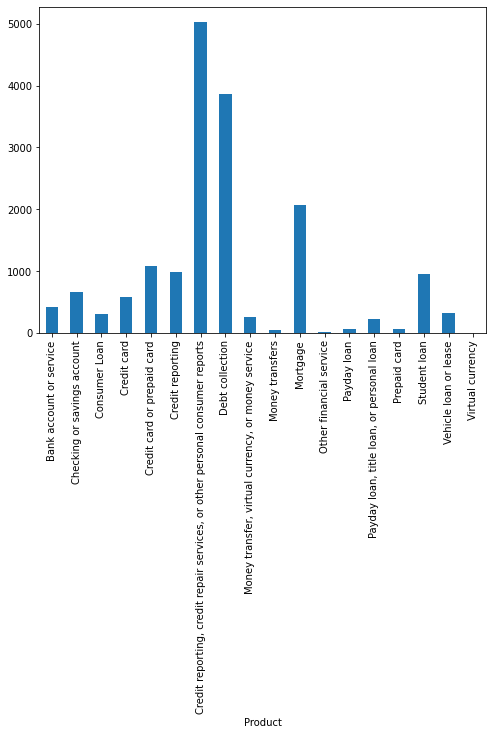

In [64]:
fig = plt.figure(figsize=(8,6))
complaints.groupby('Product')["Consumer complaint narrative"].count().plot.bar(ylim=0)
plt.show()

**Q12.** What can you observe about the number of complaints per product? How might this affect our analysis?

We can see that the product "credit reporting, credit repair service, or other personal consumer reports" has a high number of complaints. This product is very general in its description which can affect the results of the analysis. In particular, it might affect the conclusions that one can extract from the results. Debt collection and mortgage also have a high amount of complaints. The narrative corpus will therefore mostly include text about these specific products which also affects the usefulness for other products negatively.

### Classifier with no data pre-processing

We will use the `LinearSVC` model from `sklearn` to create our classifier. We will use the `CountVectorizer` and then the `TfidfTransformer` to create an input TF-IDF matrix that we will train our model with, alongside the relevant labels.

When training a model, we take an input dataset, in our case the input complaints records, and split it into a training dataset and a test dataset. This allows us to train the model with labelled data, and then test the trained model with labeled data that was not used in the training process. The `train_test_split()` function by default split the input data into 75% training data and 25% test data.

Run the next cell to train the model on the input `complaints` data that we loaded earlier:

In [65]:
X_train, X_test, y_train, y_test = train_test_split(complaints['Consumer complaint narrative'], 
                                                    complaints.Product, random_state=0)
count_vectorizer = CountVectorizer(stop_words=None)
X_train_counts = count_vectorizer.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
model = LinearSVC()
classifier = model.fit(X_train_tfidf, y_train)

We can now test out classifer against the test data `X_test`. We have to firstly vectorize the input data, then pass it to the `predict()` function of the classifier. We then build a `DataFrame` so we can inspect the predicted categories against the actual categories:

In [66]:
vec = count_vectorizer.transform(X_test)
predictions = classifier.predict(vec)
results = pd.DataFrame({
    "Complaint narrative": X_test,
    "Actual category": y_test,
    "Predicted category": predictions
})
results

,Complaint narrative,Actual category,Predicted category
32788,I have had a private loan through XXXX College...,Student loan,Student loan
58154,THIS IS NOT A DUPLICATE COMPLAINT.THIS IS A NE...,Mortgage,Mortgage
7968,Data breach by Equifax- their records indicate...,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."
17504,"After a divorce, I was granted Innocent Spouse...",Credit reporting,"Credit reporting, credit repair services, or o..."
55380,In XXXX of XXXX our home was damaged by ...,Mortgage,Mortgage
...,...,...,...
3505,I have been trying to work with Caliber Home L...,Mortgage,Mortgage
97567,I am getting repeated calls from a company cal...,Debt collection,Debt collection
62029,US Dept. of Education Student Loan : This loan...,Debt collection,Student loan
7616,"On XX/XX/XXXX XXXX XXXX XXXX, Suntrust XXXX XX...","Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."


By inspecting the results table above, we can see if the classifier has done a good or bad job (it should have done an OK job). However, we can quantify the accuracy. We do this using cross-validation. `sklearn` allows us to do this with the `cross_val_score()` function.

Run the next cell to run cross-validation on our classifier:

In [67]:
tdf_vectorizer = TfidfVectorizer(min_df=1)
no_pprocess_scores = cross_val_score(classifier, tdf_vectorizer.fit_transform(X_test), predictions, scoring='accuracy', cv=5)
no_pprocess_scores

array([0.79245283, 0.79127358, 0.80755608, 0.80755608, 0.80165289])

### Classifier with truncation of stop words

Next, we will create a classifier using the stopwords we used earlier from the `textmining` package, and then run the cross-validation on the results.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(complaints['Consumer complaint narrative'], 
                                                    complaints.Product, random_state=0)
stopped_count_vect = CountVectorizer(stop_words=tm.stopwords)
X_train_counts = stopped_count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
stopped_classifier = LinearSVC().fit(X_train_tfidf, y_train)

In [69]:
tdf_vectorizer = TfidfVectorizer(min_df=1)
stopped_predictions = stopped_classifier.predict(stopped_count_vect.transform(X_test))
stopped_scores = cross_val_score(stopped_classifier, tdf_vectorizer.fit_transform(X_test), stopped_predictions, scoring='accuracy', cv=5)
stopped_scores

array([0.81721698, 0.81367925, 0.80637544, 0.82172373, 0.83116883])

### Classifier with stemming

Next, we will create a classifier but apply stemming to our input data, using the stemming function we defined earlier `stem_doc`. We then run the cross-validation on the results.

In [70]:
stemmed_complaints = complaints.copy()
stemmed_complaints['Consumer complaint narrative'] = complaints['Consumer complaint narrative'].apply(stem_doc)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(stemmed_complaints['Consumer complaint narrative'], 
                                                    stemmed_complaints.Product, random_state=0)
stemmed_count_vect = CountVectorizer()
X_train_counts = stemmed_count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
stemmed_classifier = LinearSVC().fit(X_train_tfidf, y_train)

In [72]:
tdf_vectorizer = TfidfVectorizer(min_df=1)
stemmed_predictions = stemmed_classifier.predict(stemmed_count_vect.transform(X_test))
stemmed_scores = cross_val_score(stemmed_classifier, tdf_vectorizer.fit_transform(X_test), stemmed_predictions, scoring='accuracy', cv=5)
stemmed_scores

array([0.80896226, 0.81367925, 0.80755608, 0.81463991, 0.81463991])

### Comparison of accuracies

You can probably see from each of the cross-validation results the general accuracies, but to make things a little bit clearer we can build a `DataFrame` to compare these, and the visualize the results. We will do this twice, so we have written a function to builds the comparison for us:

In [73]:
def cross_val_comparison(labels, scores):
    d = {}
    for x, y in zip(labels, scores):
        d[x] = y
    cross_val_scores = pd.DataFrame(d)
    _ = cross_val_scores.boxplot().set_title(
        "Cross validation scores trained on {} records".format(len(complaints)))
    return cross_val_scores

Let us first look at the cross-validation scores for 100000 records as input to our models:

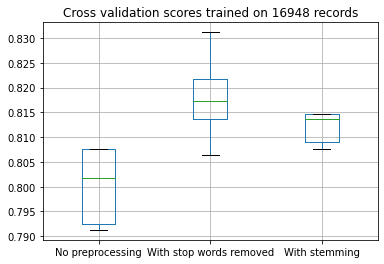

In [74]:
if len(complaints) > 1000:    
    cross_val_scores_100k = cross_val_comparison(
        ('No preprocessing', 'With stop words removed', 'With stemming'),
        (no_pprocess_scores, stopped_scores, stemmed_scores))
    cross_val_scores_100k.mean()

**Q13.** What do you observe about the cross-validated accuracies using Linear SVC without pre-processed features, stop word removed features, and stemmed features? Can you explain the reasons behind your observation(s)?

The cross-validation shows that the accuracies are rather close, but the highest accuracies come from the records that have stopwords removed from them. This seems logical since the stopwords were removed because they wouldn't provide any usefulness in the model accuracy. The stemmed features provide a higher accuracy than the text with no proprocessing, but generally a bit lower than the records without stop words. This is also logical since the stemming function helps with extracing the root words from the records.

**Re-run your analysis using only 1000 records from the input complaints dataset.**

*Hint: You need to change the number of input rows loaded at the beginning of the [Training of SVM and classification](#Training-of-SVM-and-classification) section by setting `nrows=1000`, then re-run the code cells that come afterwards. Instead of producing the boxplot that precedes 4.13, skip that cell and run the code cell below so that you can compare the results.*

No preprocess scores: [0.72727273 0.5        0.7        0.8        0.6       ]
Stopped scores: [0.63636364 0.6        0.6        0.5        0.6       ]
Stemmed scores: [0.81818182 0.7        0.9        0.7        0.8       ]


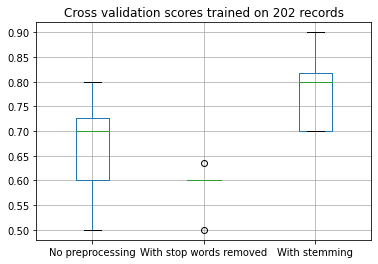

In [100]:
complaints = pd.read_csv(gdrive + "Consumer_Complaints-sliced.tar.gz", nrows=1000).dropna(subset=["Consumer complaint narrative"])
#complaints = pd.read_csv(gdrive + "Consumer_Complaints-sliced.tar.gz", nrows=13000).dropna(subset=["Consumer complaint narrative"])

X_train, X_test, y_train, y_test = train_test_split(complaints['Consumer complaint narrative'], 
                                                    complaints.Product, random_state=0)
count_vectorizer = CountVectorizer(stop_words=None)
X_train_counts = count_vectorizer.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
model = LinearSVC()
classifier = model.fit(X_train_tfidf, y_train)

vec = count_vectorizer.transform(X_test)
predictions = classifier.predict(vec)
results = pd.DataFrame({
    "Complaint narrative": X_test,
    "Actual category": y_test,
    "Predicted category": predictions
})
results

tdf_vectorizer = TfidfVectorizer(min_df=1)
no_pprocess_scores = cross_val_score(classifier, tdf_vectorizer.fit_transform(X_test), predictions, scoring='accuracy', cv=5)
no_pprocess_scores
print(f"No preprocess scores: {no_pprocess_scores}")

# With stop words removed:
X_train, X_test, y_train, y_test = train_test_split(complaints['Consumer complaint narrative'], 
                                                    complaints.Product, random_state=0)
stopped_count_vect = CountVectorizer(stop_words=tm.stopwords)
X_train_counts = stopped_count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
stopped_classifier = LinearSVC().fit(X_train_tfidf, y_train)

tdf_vectorizer = TfidfVectorizer(min_df=1)
stopped_predictions = stopped_classifier.predict(stopped_count_vect.transform(X_test))
stopped_scores = cross_val_score(stopped_classifier, tdf_vectorizer.fit_transform(X_test), stopped_predictions, scoring='accuracy', cv=5)
print(f"Stopped scores: {stopped_scores}")

# With stemming:
stemmed_complaints = complaints.copy()
stemmed_complaints['Consumer complaint narrative'] = complaints['Consumer complaint narrative'].apply(stem_doc)

X_train, X_test, y_train, y_test = train_test_split(stemmed_complaints['Consumer complaint narrative'], 
                                                    stemmed_complaints.Product, random_state=0)
stemmed_count_vect = CountVectorizer()
X_train_counts = stemmed_count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
stemmed_classifier = LinearSVC().fit(X_train_tfidf, y_train)

tdf_vectorizer = TfidfVectorizer(min_df=1)
stemmed_predictions = stemmed_classifier.predict(stemmed_count_vect.transform(X_test))
stemmed_scores = cross_val_score(stemmed_classifier, tdf_vectorizer.fit_transform(X_test), stemmed_predictions, scoring='accuracy', cv=5)
print(f"Stemmed scores: {stemmed_scores}")

if len(complaints) < 1000:
#if len(complaints) < 100000:
    cross_val_scores_1k = cross_val_comparison(
        ('No preprocessing', 'With stop words removed', 'With stemming'),
        (no_pprocess_scores, stopped_scores, stemmed_scores))
    cross_val_scores_1k.mean()

**Q14.** Does this affect your previous observations? If so, provide possible reasons.

It does affect my previous observations. The accuracy of the model using removed stop words is the worst one. I believe that this is because the model doesn't have enough data to train on when the stopwords are removed. 

I confirmed this by changing the number of rows in the data, and what I noticed is that the model with stop words removed started getting the best accuracy when 13000 rows were used. This means that removal of stop words starts being most effective when the number of rows is increased to 13 times higher than 1000 (13000).

Otherwise, the stemming model is still achieving higher accuracy than the model with no preprocessing which aligns with the result seen before.

---
You're done with Lab 3b!

Choose **Save and Checkpoint** from the **File** menu to save your work.

If you are running the labs in Binder (on the cloud), then choose **Download as Notebook** and save it to your computer. 

Now *ZIP* all two Lab 2 notebooks together into one file and [upload it to Studium](https://uppsala.instructure.com/courses/26106/assignments/37616).